# A notebook for testing the Solar Panel Simulation packages

## Dependencies
* `bms` -- a package to battery management system
* `nav` -- the "navigation" package, which in the current implementation is mostly a wrapper for `luseepy` objects

## Calculations vs cache

Calculating the path of the sun for extended periods of time can take a while, so
there are helper scripts that can do that once and save these data to disk, which
can be read quickly.




In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Basic toolkit dependencies:
import  numpy as np
import  matplotlib.pyplot as plt

# Local imports
# Local power-related packages:
import bms
import nav # Includes the Sun class

from bms import *
from nav import *

print(f'''BMS package bersion:  {bms.__version__}''')
print(f'''NAV package bersion:  {nav.__version__}''')
print(f'''Name reported by the Panel class: {Panel.name}''')
print(f'''Panel PV efficiency at 0C: {Panel.pvEfficiency(0.0)}''')


BMS package bersion:  0.1
NAV package bersion:  0.1
Name reported by the Panel class: Base Panel Class.
Panel PV efficiency at 0C: 0.312152988744667


Text(0.5, 1.0, 'SolAero IMM-beta space solar cell')

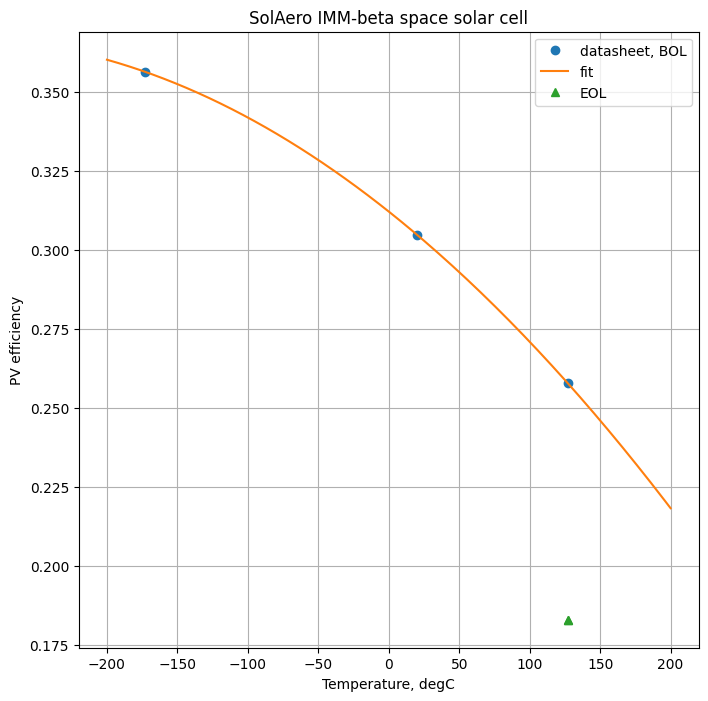

In [2]:
# Test the efficiency-temperature function
plt.rcParams["figure.figsize"] = [8., 8.]

plt.plot([-173.15, 20, 126.85], np.array([152, 130, 110]) / 426.47, 'o', label='datasheet, BOL')
plt.plot(np.linspace(-200,200,200), Panel.pvEfficiency(np.linspace(-200,200,200)), label='fit')
plt.plot([126.85, 126.85],[.183,.183], '^', label='EOL')
plt.xlabel('Temperature, degC')
plt.ylabel('PV efficiency')
plt.grid(True)
plt.legend()
plt.title("SolAero IMM-beta space solar cell")

In [8]:
###############################################################################
# Read the prefab data on sun trajectory
import os
print('Current directory:', os.getcwd())
mySun = Sun()

cachefile = '../data/2025-02-04_03-07.npy'
mySun.read(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')

# try:
#     with open(cachefile, 'rb') as f: mjd_alt_az = np.load(f)
#     print(f'''Loaded data from file {cachefile}''')

#     mjd = mjd_alt_az[:,0]
#     alt = mjd_alt_az[:,1]
#     az  = mjd_alt_az[:,2]
#     print('Number of points:', az.size)
# except:
#     print(f'''ERROR: file {cachefile} not found''')


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Loaded data from file "../data/2025-02-04_03-07.npy", number of points for the three components: 8979
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


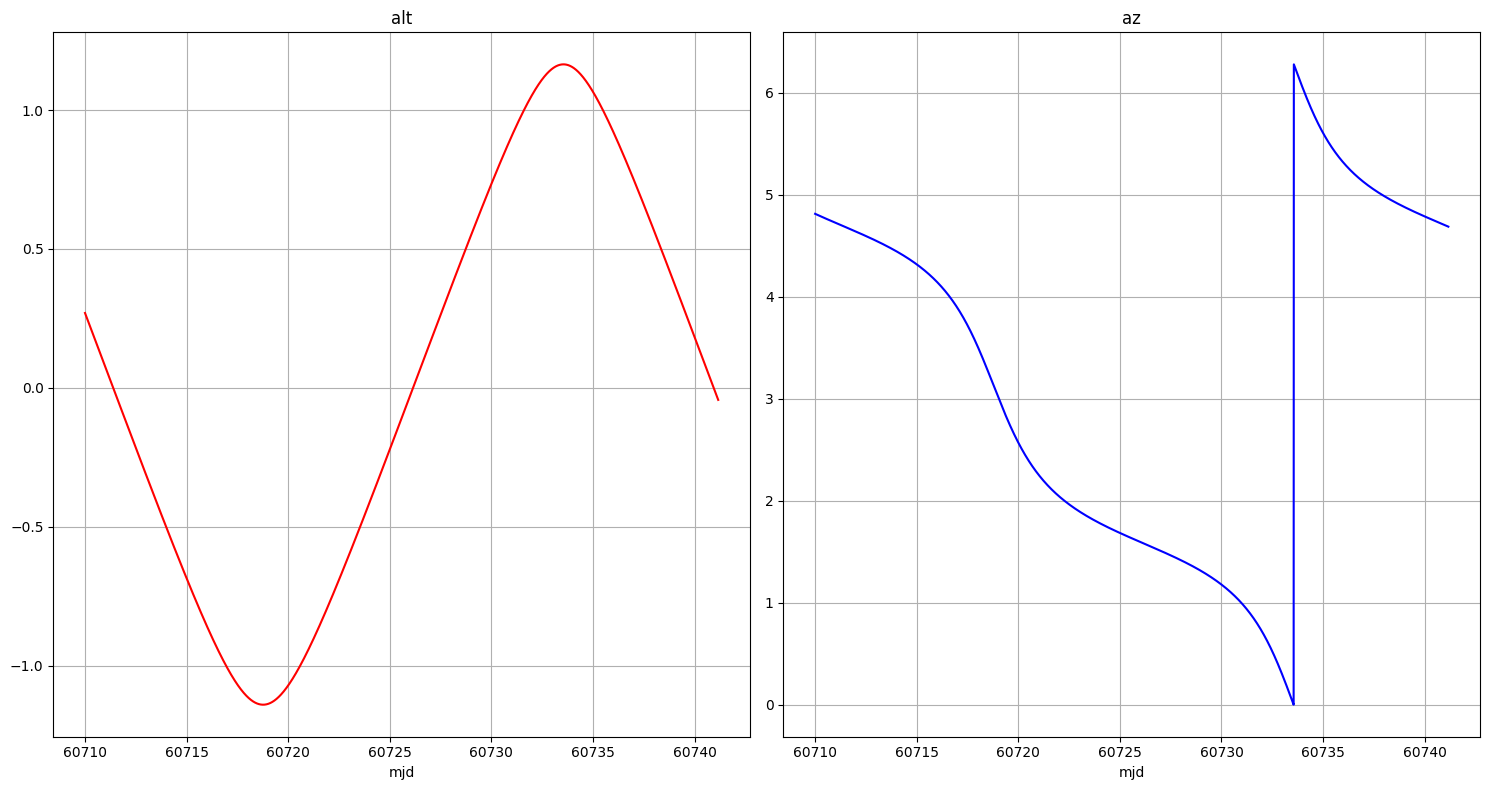

In [9]:
fig, (p1, p2) = plt.subplots(1,2)

plt.rcParams["figure.figsize"] = [15., 8.]
plt.rcParams["figure.autolayout"] = True

p1.set_title("alt")
p1.plot(mjd, alt, color="red")
p1.grid(True)
p1.set_xlabel('mjd')

y = np.array(az)
p2.set_title("az")
p2.plot(mjd, az, color="blue")
p2.grid(True)
p2.set_xlabel('mjd')
plt.show()

2993 2993
[355.   355.25 355.5  355.75 356.   356.25 356.5  356.75 357.   357.25
 357.5  357.75 358.   358.25 358.5  358.75 359.   359.25 359.5  359.75
 360.   360.25 360.5 ] [1.00153569 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


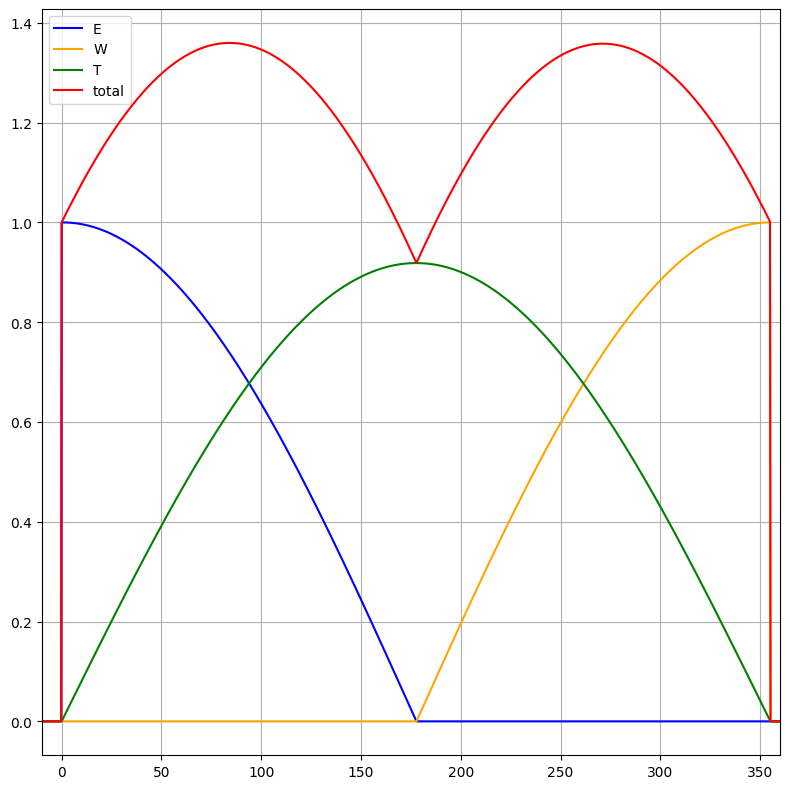

In [5]:
from bms.parts import Battery, Controller

battery = Battery() # a dummy battery here, just to create the controller
ctr     = Controller(battery)

alt_sun_top = np.asarray(alt)+sun_rad

sun     = altaz2xyz(alt, az)
sun_top = altaz2xyz(alt_sun_top, az)

e = EPanel(sun, 'E')
ctr.add_panel(e)

w = WPanel(sun, 'W')
ctr.add_panel(w)

t = TPanel(sun, 'T')
ctr.add_panel(t)

# ---------------------------------------------------------
condition_list = [alt>horizon+sun_rad, alt>horizon, alt>horizon-sun_rad, alt<=horizon-sun_rad]
ctr.set_condition(condition_list)

hrs = hrsFromSunrise(alt, mjd)

ePower = e.power()
wPower = w.power()
tPower = t.power()

totalPower = ctr.panels_power()

plt.rcParams["figure.figsize"] = [8., 8.]
plt.rcParams["figure.autolayout"] = True
plt.plot(hrs,   ePower,     color="blue",   label="E")
plt.plot(hrs,   wPower,     color="orange", label="W")
plt.plot(hrs,   tPower,     color="green",  label="T") 
plt.plot(hrs,   totalPower, color="red",    label="total")
plt.xlim(-10, 360)
plt.grid(True)
plt.legend()

print(hrs.size, totalPower.size)
print(hrs[2970:], totalPower[2970:])


Text(0.5, 1.0, 'Alt vs Hours to sunrise')

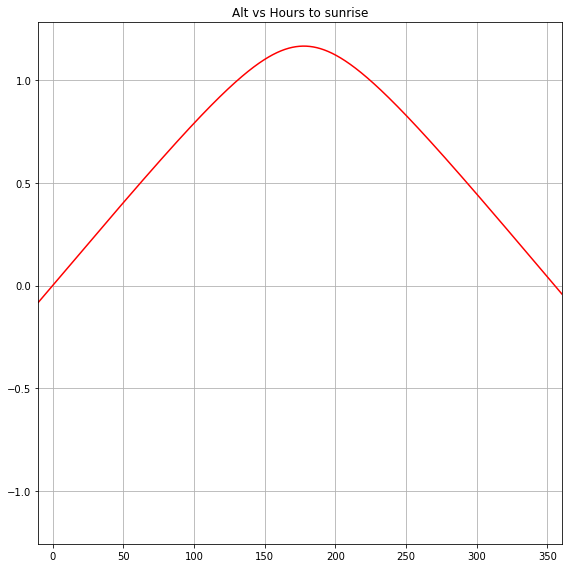

In [82]:
plt.plot(hrs,   alt, color="red",    label="Alt")
plt.xlim(-10, 360)
plt.grid(True)
plt.title("Alt vs Hours to sunrise")


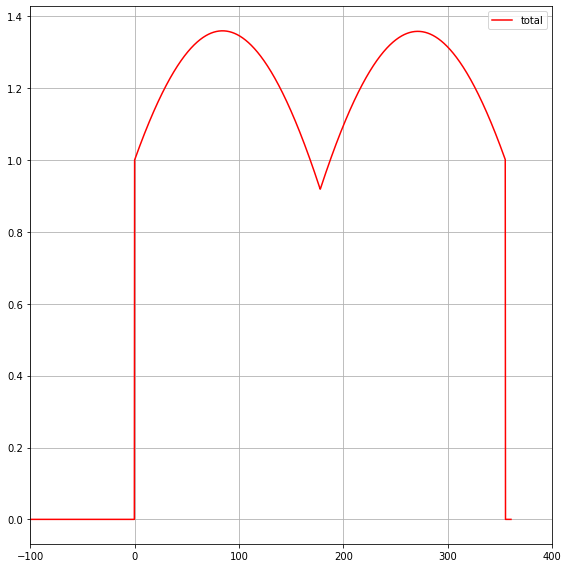

In [11]:
# Shorter example demonsrtating wrappers
# We assume that nav parameters -- alt, z, on mjd points -- have been calculated above...

from bms.parts          import Battery, Controller
from nav.coordinates    import *

mySun = Sun(mjd, alt, az)

battery = Battery(0.0) # Dummy battery, just to satisfy the controller
ctr     = Controller(battery)
ctr.add_all_panels(sun)
ctr.set_condition(sun_condition(alt))
hrs = hrsFromSunrise(alt, mjd)

plt.plot(hrs, ctr.panels_power(), color="red",    label="total")
plt.xlim(-100,400)
plt.grid(True)
plt.legend()


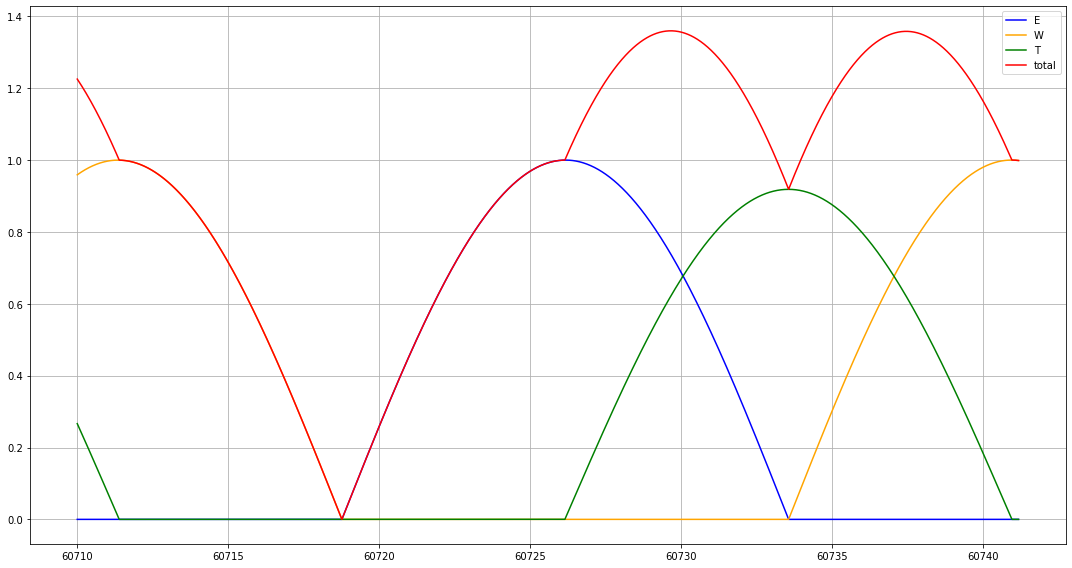

In [17]:
############################################ OPTIONAL: Panel power plot w/o the conditions ###############

t_dot_sun_top = t.dot(sun_top)
# For finite disk at sunrise/sunset. Slight aprx: top of sun not center of segment
t_dot_sun_top[t_dot_sun_top < 0] = 0.0


plt.rcParams["figure.figsize"] = [15., 8.]
plt.rcParams["figure.autolayout"] = True

plt.plot(mjd, e.dot_sun, color="blue", label="E")
plt.plot(mjd, w.dot_sun, color="orange", label="W")
plt.plot(mjd, t.dot_sun, color="green", label="T")

tot = e.dot_sun + w.dot_sun + t.dot_sun

plt.plot(mjd, tot, color="red",    label="total")

plt.grid(True)
plt.legend()
plt.show()

# Sanitize input to arccos and sqrt. Values where h<0 are non-physical and will be cut by condition_list.
# alt_seg = np.abs(alt)
# alt_seg[alt_seg>sun_rad]=sun_rad
# sun_seg_area = (sun_rad**2)*np.arccos(1-((sun_rad-alt_seg)/sun_rad))-alt_seg*np.sqrt((sun_rad**2)-(alt_seg)**2)
# sun_seg_frac = sun_seg_area/(np.pi*sun_rad**2)

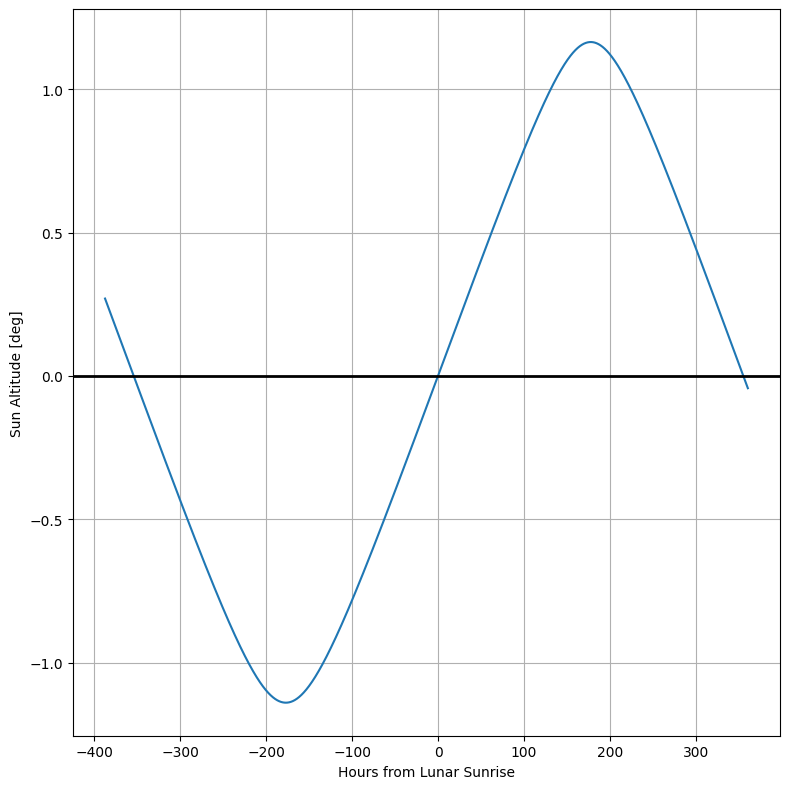

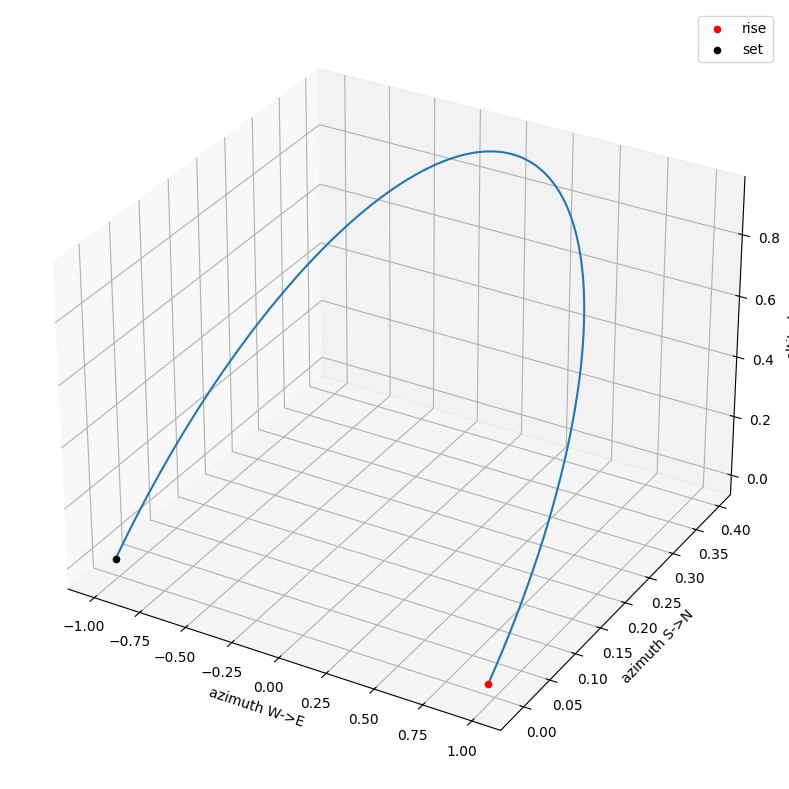

In [6]:
# transitions
iMidnight       = np.argmin(alt)
iNoon           = np.argmax(alt)
iSundown1       = np.argmin(np.abs(alt[:iMidnight]))
iSunrise        = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
iSundown2       = np.argmin(abs(alt[iNoon:])) + iNoon
hoursFromSunset = (mjd - mjd[iSundown1])*24
hoursFromSunrise= (mjd - mjd[iSunrise])*24

t_inc = 0.25 #Varies! But approx 0.25hrs ticks

alt_sun_top = np.asarray(alt)+0.265
iSuntoprise = np.argmin(np.abs(alt_sun_top[iMidnight:iNoon])) + iMidnight
iSuntopdown2 = np.argmin(abs(alt_sun_top[iNoon:])) + iNoon

# plot altitude through the cycle
plt.plot(hoursFromSunrise,alt, label='Alt')
plt.axhline(0, c='k', lw=2)
plt.grid(True)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Sun Altitude [deg]")

# plot track of sun in 3D during 1 lunar day
plt.figure()
ax = plt.axes(projection='3d')
# day_mask = alt > 0
day_mask = [False]*len(alt) | (alt>0)
for i in range(len(day_mask)):
    if (i<iMidnight):
        day_mask[i] = False

sun = altaz2xyz(alt, az)
sunDay = altaz2xyz(alt, az)[day_mask]

ax.plot3D(sunDay[:,0],sunDay[:,1],sunDay[:,2])
ax.scatter3D(sunDay[0,0],sunDay[0,1],sunDay[0,2], c='r', label='rise')
ax.scatter3D(sunDay[-1,0],sunDay[-1,1],sunDay[-1,2], c='k', label='set')

ax.set_xlabel('azimuth W->E')
ax.set_ylabel('azimuth S->N')
ax.set_zlabel('altitude')
ax.legend()
